<a href="https://colab.research.google.com/github/Harshpatel44/ML-A4/blob/master/De_noising_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
Authors: 
          Yashesh Savani (B00838567)
          Harsh Patel    (B00845449)
```



In [0]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as Func 
import time
global_a=time.time()

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


**Fetching Data, Assigning Variance for further use**

In [0]:
mnist = datasets.fetch_openml('mnist_784')

In [0]:
#fn for standard scaling
def scaling(train_,test_):
  scalar = StandardScaler()
  scalar.fit(train_)
  train_=scalar.transform(train_)
  test_=scalar.transform(test_)
  return train_,test_

#fn for plotting all variances
def plot_variances(digits,labels,iteration=3,tight=1):
  fig = plt.figure()
  for i in range(iteration):
    plt.subplot(3,3,i+1)
    if(tight==1):
      plt.tight_layout()
    try:
      plt.imshow(np.reshape(digits,(60000,28,28))[i], cmap='gray', interpolation='none')
    except:
      plt.imshow(np.reshape(digits,(10000,28,28))[i], cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(labels[i]))
    plt.xticks([])
    plt.yticks([])
#fn for converting multi-numpy arrays to torch
def numpy_to_torch(*args):
  temp=[]
  for i in args:
    temp.append(torch.from_numpy( i[0].astype( str(i[1]) )).to( i[2] ))
  return temp

In [0]:
train = mnist.data[:60000,:]
test =  mnist.data[60000:,:]
y_train = mnist.target[:60000]
y_test =  mnist.target[60000:]

#train_,test_=scaling(train,test)
train_=np.clip(train,0.,1.)
test_=np.clip(test,0.,1.)

y_train,y_test=numpy_to_torch([y_train,"int64","cpu"],[y_test,"int64","cpu"])

In [0]:
import torch.nn as nn
import torch.nn.functional as F
def Denoising(noisy_images,true_images,test_images,batch_size=100,epochs=20,dev='cuda'):
  losses=[]
  noisy_images=noisy_images.view(-1,1,28,28)
  test_images=test_images.view(-1,1,28,28)
  true_images=true_images.view(-1,1,28,28)
  train_loader = torch.utils.data.DataLoader(noisy_images,batch_size=batch_size,shuffle=False)
  true_loader = torch.utils.data.DataLoader(true_images,batch_size=batch_size,shuffle=False)
  test_loader= torch.utils.data.DataLoader(test_images,batch_size=batch_size,shuffle=False)

  class denoise_model(nn.Module):
      def __init__(self):
          super(denoise_model, self).__init__()
          # encoder
          self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
          self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
          self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
          self.pool = nn.MaxPool2d(2, 2)
          
          # decoder
          self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2) 
          self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
          self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
          self.conv_out = nn.Conv2d(32, 1, 3, padding=1)

      def forward(self, x):
          #encoding
          x = F.relu(self.conv1(x))
          x = self.pool(x)
          x = F.relu(self.conv2(x))
          x = self.pool(x)
          x = F.relu(self.conv3(x))
          x = self.pool(x)  
          
          #decoding
          x = F.relu(self.t_conv1(x))
          x = F.relu(self.t_conv2(x))
          x = F.relu(self.t_conv3(x))
          x = torch.sigmoid(self.conv_out(x))   
          return x

      def reconstruct(self,x):
          #encoding
          x = F.relu(self.conv1(x))
          x = self.pool(x)
          x = F.relu(self.conv2(x))
          x = self.pool(x)
          x = F.relu(self.conv3(x))
          x = self.pool(x)  
          #decoding
          x = F.relu(self.t_conv1(x))
          x = F.relu(self.t_conv2(x))
          x = F.relu(self.t_conv3(x))
          x = torch.sigmoid(self.conv_out(x)) 
          return x

  # initialize the NN
  model = denoise_model()
  if(dev=='cuda'):
    model.cuda()
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  for epoch in range(1, epochs+1):
      for noisy,true in zip(train_loader,true_loader):
          optimizer.zero_grad()
          if(dev=='cuda'):
            noisy=noisy.cuda()
            true=true.cuda()
          outputs = model(noisy)
          loss = criterion(outputs, true)
          loss.backward()
          optimizer.step()
          losses.append(loss.item())
          del loss,outputs,noisy,true
      print("Epoch:",epoch,"Loss:",losses[-1])

  temp_loader= torch.utils.data.DataLoader(noisy_images,batch_size=10000,shuffle=False)
  count=0
  with torch.no_grad():
      for inputs in temp_loader:
        if(count==0):
            train_outputs = model(inputs.cuda())
        else:
            temp = model(inputs.cuda())
            train_outputs=torch.cat((train_outputs,temp),0)
        count+=1
      
  count=0
  temp_loader= torch.utils.data.DataLoader(test_images,batch_size=10000,shuffle=False)
  with torch.no_grad():    
      for inputs in temp_loader:  
        if(count==0):
          test_outputs = model(inputs.cuda())
        else:
            temp = model(inputs.cuda())
            test_outputs=torch.cat((test_outputs,temp),0)
        count+=1
      del temp,temp_loader,count

  return train_outputs.detach(),test_outputs.detach()

In [0]:
#creating noisy image by reconstructing from PCA
variance=0.90
pca=decomposition.PCA(variance)
pca.fit(train_)
noisy_images_train = pca.transform(train_)
noisy_images_test = pca.transform(test_)

noisy_images_train = pca.inverse_transform(noisy_images_train)
noisy_images_test = pca.inverse_transform(noisy_images_test)

noisy_images_train = torch.Tensor(noisy_images_train) #converting to tensor
noisy_images_test = torch.Tensor(noisy_images_test) #converting to tensor

train_= torch.Tensor(train_)
test_ = torch.Tensor(test_)

Reconstructed Image from PCA

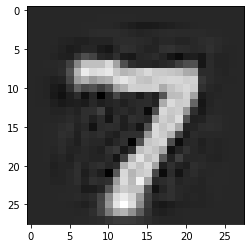

In [83]:
plt.imshow(np.reshape(noisy_images_test,(10000,28,28))[0], cmap='gray', interpolation='none')
plt.title("Digit: {}".format(test[i]))

**Running Autoencoder to denoise the reconstructed PCA image**

In [84]:
#running the model
reconstructed_train,reconstructed_test=Denoising(noisy_images_train,train_,noisy_images_test,100,20,'cuda')  #epohes=10, batch_size=100

Epoch: 1 Loss: 0.05834583565592766
Epoch: 2 Loss: 0.047503527253866196
Epoch: 3 Loss: 0.0416128896176815
Epoch: 4 Loss: 0.038171879947185516
Epoch: 5 Loss: 0.03640158474445343
Epoch: 6 Loss: 0.03520035743713379
Epoch: 7 Loss: 0.03415882959961891
Epoch: 8 Loss: 0.033134881407022476
Epoch: 9 Loss: 0.03243403881788254
Epoch: 10 Loss: 0.03204987943172455
Epoch: 11 Loss: 0.0317658931016922
Epoch: 12 Loss: 0.031448476016521454
Epoch: 13 Loss: 0.031207634136080742
Epoch: 14 Loss: 0.031101185828447342
Epoch: 15 Loss: 0.030882712453603745
Epoch: 16 Loss: 0.030655337497591972
Epoch: 17 Loss: 0.03042210452258587
Epoch: 18 Loss: 0.03011801652610302
Epoch: 19 Loss: 0.0298476479947567
Epoch: 20 Loss: 0.029578574001789093


**Denoised Image**

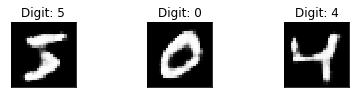

In [85]:
reconstructed_train=reconstructed_train.view(60000,28,28)
plot_variances(reconstructed_train.cpu().detach().numpy(),y_train,3,1)

**Original Image**

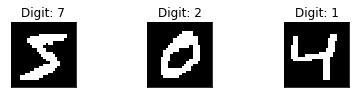

In [86]:
plot_variances(train_,y_test,3,1)

**Training Denoised Image on CNN and Evaluating Results**

In [0]:
def cnn_Model(train_,test_,y_train_,y_test_,epochs=2,batch_size=100,filter_size=3,pool_size=2,lr=0.001,dev='cpu'):
  train_=train_.view(-1,1,28,28)
  test_=test_.view(-1,1,28,28)
  training_acc=[]
  testing_acc=[]
  ip_channel=1
  op_channel= 6
  conv_strides=1
  pool_strides=1
  loss_list=[]

  #formula to measure the output from convolution and pooling
  op_conv1 = (( train_.shape[2] - filter_size) / conv_strides) +1
  max_pool1 = (( op_conv1 - pool_size)/pool_strides) + 1
  
  train_loader = torch.utils.data.DataLoader(train_, batch_size=batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_, batch_size=batch_size, shuffle=False)
  y_train_loader = torch.utils.data.DataLoader(y_train_, batch_size=batch_size, shuffle=False)
  y_test_loader = torch.utils.data.DataLoader(y_test_, batch_size=batch_size, shuffle=False)

  class net(nn.Module):  
    def __init__(self):
      super(net,self).__init__()      
      if(str(dev)=='cuda'): 
        #print('running on cuda')
        self.conv1 = nn.Conv2d(ip_channel,op_channel,filter_size).cuda()
        self.pool = nn.MaxPool2d(pool_size,pool_strides).cuda()
        self.fc1 = nn.Linear(int(op_channel*max_pool1*max_pool1),84).cuda()
        self.fc2 = nn.Linear(84,10).cuda()
      else:
        #print('running on cpu')
        self.conv1 = nn.Conv2d(ip_channel,op_channel,filter_size)
        self.pool = nn.MaxPool2d(pool_size,pool_strides)
        self.fc1 = nn.Linear(int(op_channel*max_pool1*max_pool1),84)
        self.fc2 = nn.Linear(84,10)
    def forward(self,x):
      x = self.pool(Func.relu(self.conv1(x)))
      x=x.view(-1,int(op_channel*max_pool1*max_pool1))
      x=Func.relu(self.fc1(x))
      x=Func.log_softmax(self.fc2(x),dim=1)
      return x
  Net = net()
  if(dev=='cuda'):
    #print('device set on cuda')
    Net.to(device)  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.RMSprop(Net.parameters(), lr = lr)

  def train_eval():
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs,labels in zip(train_loader,y_train_loader):
          if(dev=='cuda'):
              inputs = inputs.to(device)
              labels = labels.to(device)
          outputs = Net(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
    train_acc = correct / total
    training_acc.append(train_acc)

  def test_eval():
    correct = 0
    total = 0
    with torch.no_grad():    
        for inputs,labels in zip(test_loader,y_test_loader):  
          if(dev=='cuda'):
              inputs = inputs.to(device)
              labels = labels.to(device)
          outputs = Net(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
    test_acc = correct / total
    testing_acc.append(test_acc)

  for e in range(epochs):
    for inputs,labels in zip(train_loader,y_train_loader):
      if(dev=='cuda'):
            inputs = inputs.to(device)
            labels = labels.to(device)
      optimizer.zero_grad()
      outputs = Net(inputs)
      loss = criterion(outputs,labels)
      loss.backward()
      optimizer.step()
      loss_list.append(loss.item())
    print("Epoch",e,"loss",loss)
  train_eval()
  test_eval()

  del Net,outputs,inputs,labels,train_,test_
  return loss_list, training_acc, testing_acc

Training the Denoised Data on CNN model (which had variance=90%)

CNN Net on Reconstructed Images:
Epoch 0 loss tensor(0.3069, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 1 loss tensor(0.2817, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 2 loss tensor(0.2793, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 3 loss tensor(0.2466, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 4 loss tensor(0.3394, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 5 loss tensor(0.2778, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 6 loss tensor(0.2226, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 7 loss tensor(0.2146, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 8 loss tensor(0.2099, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 9 loss tensor(0.1943, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 10 loss tensor(0.1872, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 11 loss tensor(0.1989, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 12 loss tensor(0.1817, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 13 loss tensor(0.1836,

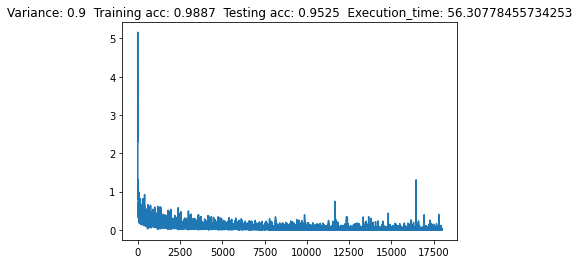

In [88]:
def testing_reconstructed_1(denoised_train,denoised_test,y_train,y_test,variance):
  print('CNN Net on Reconstructed Images:')
  #for i in reconstructed_images:
    #data manipulated for standard scaling, and again converted to vector
  denoised_train=denoised_train.reshape((60000,784)).cpu().detach().numpy()
  denoised_test=denoised_test.reshape((10000,784)).cpu().detach().numpy()
  denoised_train,denoised_test=scaling(denoised_train,denoised_test)
  denoised_train=torch.from_numpy(denoised_train)
  denoised_test=torch.from_numpy(denoised_test)
  
  a=time.time()
  losses,cnn_train_acc,cnn_test_acc = cnn_Model(denoised_train,denoised_test,y_train,y_test,30,100,4,2,0.001,'cuda') #epochs,batch_size,filter_size,pool_size
  b=time.time()

  plt.plot(losses)
  plt.title("Variance: "+str(variance)+"  Training acc: "+str(cnn_train_acc[-1])+"  Testing acc: "+str(cnn_test_acc[-1])+"  Execution_time: "+str(b-a))
  plt.show()

import time
testing_reconstructed_1(reconstructed_train,reconstructed_test,y_train,y_test,variance)

Here we get Training Accuracy- 98.87% and Testing Accuracy-95.25%

2. Testing the reconstructed PCA data which has variance=0.50)

CNN Net on Reconstructed Images:
Epoch 0 loss tensor(0.3147, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 1 loss tensor(0.3232, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 2 loss tensor(0.3253, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 3 loss tensor(0.3122, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 4 loss tensor(0.3031, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 5 loss tensor(0.3073, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 6 loss tensor(0.3157, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 7 loss tensor(0.3072, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 8 loss tensor(0.3053, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 9 loss tensor(0.2976, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 10 loss tensor(0.3068, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 11 loss tensor(0.2996, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 12 loss tensor(0.3006, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 13 loss tensor(0.2954,

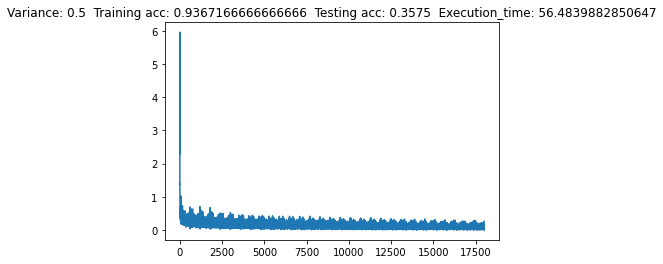

In [89]:
def testing_reconstructed_2(reconstructed_train,reconstructed_test,y_train,y_test,variance):
  print('CNN Net on Reconstructed Images:')
  #manipulation
  reconstructed_train=reconstructed_train.reshape((60000,784)).detach().numpy()
  reconstructed_test=reconstructed_test.reshape((10000,784)).detach().numpy()
  reconstructed_train,test_=scaling(reconstructed_train,reconstructed_test)
  reconstructed_train=torch.from_numpy(reconstructed_train)
  reconstructed_test=torch.from_numpy(reconstructed_test)
  
  a=time.time()
  losses,cnn_train_acc,cnn_test_acc = cnn_Model(reconstructed_train,reconstructed_test,y_train,y_test,30,100,4,2,0.001,'cuda') #epochs,batch_size,filter_size,pool_size
  b=time.time()

  plt.plot(losses)
  plt.title("Variance: "+str(variance)+"  Training acc: "+str(cnn_train_acc[-1])+"  Testing acc: "+str(cnn_test_acc[-1])+"  Execution_time: "+str(b-a))
  plt.show()
  

variance=0.50
pca=decomposition.PCA(variance)
pca.fit(train_)
pca_train = pca.transform(train_)
pca_test = pca.transform(test_)
reconstructed_train = pca.inverse_transform(pca_train)
reconstructed_test = pca.inverse_transform(pca_test)

reconstructed_train = torch.Tensor(reconstructed_train) #converting to tensor
reconstructed_test = torch.Tensor(reconstructed_test) #converting to tensor

testing_reconstructed_2(reconstructed_train,reconstructed_test,y_train,y_test,variance)

Here we get Training Accuracy- 93.67% and Testing Accuracy-35.75% . The Testing Accuracy is very less compared to our earlier result of Denoised data(variance=95%). Execution time for both the datasets is almost same.

In [90]:
global_b=time.time()
print("Total Time: ",global_b-global_a)

Total Time:  234.96648573875427


In [91]:
print("Denoising Complete")

Denoising Complete
